In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Change this to the correct path of your file in Google Drive
dataset_path = "/content/drive/My Drive/DATASETMP/CyberBullyingTypesDataset.csv"

# Load dataset
df = pd.read_csv(dataset_path)
df.head()

,Tweet,Class
0,Post-Cuomo push to toughen NY sexual harassmen...,Sexual Harassment
1,Push to toughen NY sexual harassment laws that...,Sexual Harassment
2,@GabbieHanna As if Trisha didn’t accuse him of...,Sexual Harassment
3,@fentsemadii True is that 🔥 thou I know nothin...,Sexual Harassment
4,Watch the recap video of the two-day hands-on ...,Sexual Harassment


In [ ]:
!pip install transformers datasets torch torchvision torchaudio scikit-learn pandas numpy matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install nlpaug -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

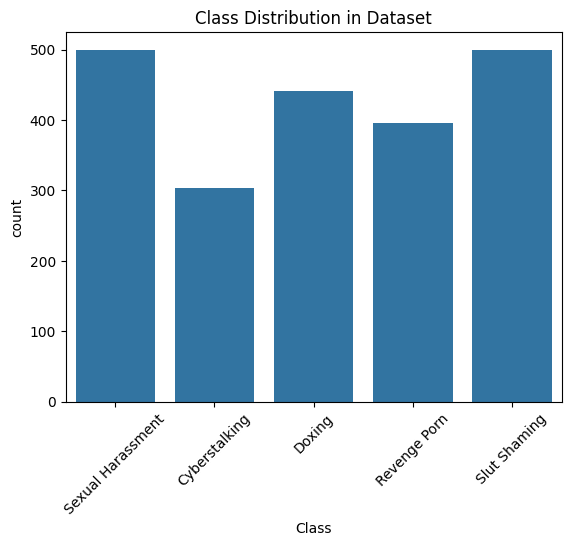

In [ ]:

# Check class distribution
sns.countplot(x=df["Class"])
plt.xticks(rotation=45)
plt.title("Class Distribution in Dataset")
plt.show()

In [ ]:
import nltk

# Download the necessary NLTK resource before applying augmentation
nltk.download('averaged_perceptron_tagger_eng')

import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and remove whitespace
    return text

from nlpaug.augmenter.word import SynonymAug
import random

def augment_text(text):
    aug = SynonymAug(aug_src='wordnet', aug_p=0.2)  # Replace 20% of words with synonyms
    augmented_text = aug.augment(text)
    return augmented_text if random.random() > 0.5 else text  # Apply augmentation 50% of the time

df["Tweet"] = df["Tweet"].apply(clean_text).apply(augment_text)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Class"])

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Tweet"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")
import torch

# Compute class weights based on the training dataset distribution
class_counts = train_labels.value_counts().sort_index().tolist()  # Get count per class
total_samples = sum(class_counts)
class_weights = [total_samples / c for c in class_counts]  # Inverse frequency method
class_weights = torch.tensor(class_weights).to("cuda")  # Convert to tensor and move to GPU

# Define custom weighted loss function
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss(weight=class_weights)


Train size: 1712, Validation size: 214, Test size: 214


In [ ]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("vinai/bertweet-large") # Load the tokenizer

train_encodings = tokenizer(
    train_texts.astype(str).tolist(),  # Convert the Series to a list of strings
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    val_texts.astype(str).tolist(), truncation=True, padding=True, max_length=512
)
test_encodings = tokenizer(
    test_texts.astype(str).tolist(), truncation=True, padding=True, max_length=512
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

In [ ]:
class CyberbullyingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add 'labels' key to the dictionary
        return item  # Return the dictionary directly
# Create dataset objects
train_dataset = CyberbullyingDataset(train_encodings, train_labels.tolist())
val_dataset = CyberbullyingDataset(val_encodings, val_labels.tolist())
test_dataset = CyberbullyingDataset(test_encodings, test_labels.tolist())

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=5)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    fp16=True,
    save_total_limit=2,
    report_to="none",  # Disable wandb logging
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import TrainerCallback
import torch.nn.functional as F

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Add **kwargs to accept extra arguments
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Apply weighted loss
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


trainer.train()

Epoch,Training Loss,Validation Loss
1,1.565300,1.562245
2,1.347900,1.008055
3,0.441200,0.552016
4,0.509200,0.569093
5,0.336300,0.821850
6,0.220900,0.718507


TrainOutput(global_step=324, training_loss=0.7850333161560106, metrics={'train_runtime': 401.8835, 'train_samples_per_second': 170.398, 'train_steps_per_second': 5.375, 'total_flos': 934853124758400.0, 'train_loss': 0.7850333161560106, 'epoch': 6.0})

In [ ]:
save_path = "/content/drive/MyDrive/FINALRESULTS/bertweet_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/FINALRESULTS/bertweet_model/tokenizer_config.json',
 '/content/drive/MyDrive/FINALRESULTS/bertweet_model/special_tokens_map.json',
 '/content/drive/MyDrive/FINALRESULTS/bertweet_model/vocab.json',
 '/content/drive/MyDrive/FINALRESULTS/bertweet_model/merges.txt',
 '/content/drive/MyDrive/FINALRESULTS/bertweet_model/added_tokens.json',
 '/content/drive/MyDrive/FINALRESULTS/bertweet_model/tokenizer.json')